# Intersects, Contains, Touches, Covered By? Spatial Relationships De-mystified

## Purpose
Any casual (or not so casual) user of GIS software will soon have a need to filter data spatially
- select all the lines interacting with this tile polygon
- filter all the addresses within this postcode area
- filter all road links intersecting the Wiltshire Council admin unit

BUT - the language used above could be ambiguous, and interpreted in different ways
- what does 'interacting with' mean
  - does it include lines that are largely outside the tile, but have one end point on the boundary of the tile
- what does 'within' mean?
  - does it include addresses on the boundary?

In order to clarify the precise meaning of the spatial relatuionships between features, we need:
- an agreed vocabulary of relationships
- an agreed set of principles relating the properties of different types of geometries

This session will describe:
- the meaning of the different types of spatial relationship and when to use them
- the spatial theory under-pinning the relationships (DE-9IM)

Hopefully this will allow people using geospatial software / libraries to be freed from defaulting to what is seen as the safe option - 'INTERSECT'!


  

## A Quick Quiz
We will look at some common spatial relationship scenarios to establish some terminology and identify some of the ambiguity

In [1]:
import geopandas as gpd
from shapely import wkt

def create_data_frame(geom_list):
    df = gpd.GeoDataFrame(columns=["id", "geometry"])
    
    for i, geom in enumerate(geom_list):
        df.loc[i] = [i, geom]
        
    return df


<AxesSubplot:>

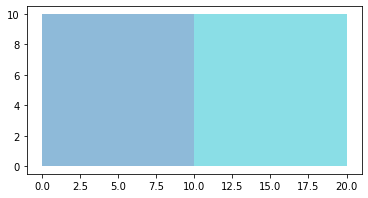

In [2]:
geom1 = wkt.loads("POLYGON((0 0, 10 0, 10 10, 0 10, 0 0))")
geom2 = wkt.loads("POLYGON((10 0, 20 0, 20 10, 10 10, 10 0))")
create_data_frame([geom1, geom2]).plot(cmap="tab10", alpha=0.5)

<AxesSubplot:>

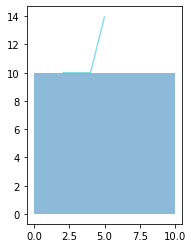

In [3]:
geom1 = wkt.loads("POLYGON((0 0, 10 0, 10 10, 0 10, 0 0))")
geom2 = wkt.loads("LINESTRING(2 10, 4 10, 5 14)")
create_data_frame([geom1, geom2]).plot(cmap="tab10", alpha=0.5)

In [ ]:
geom1 = wkt.loads("POLYGON((0 0, 10 0, 10 10, 0 10, 0 0))")
geom2 = wkt.loads("POINT(0 5)")
create_data_frame([geom1, geom2]).plot(cmap="tab10", alpha=0.5)

In [ ]:
geom1.touches(geom2)

In [ ]:
geom1.relate(geom2)

## Using the Intersection Matrix to Query for Custom Relationships
### Example 1:  Selecting features interacting with a tile
Sometimes there is a specific spatial relationship you want to filter by for which no pre-cannned named spatial relationship exists. For example:

  - for a specific rectangular tile, I want:
    - all lines completely within
    - all lines within or sharing a segment with the boundary
    - all lines partially in and partially out of the tile
    
  - I do not want:
    - lines that are completely outside
    - lines that touch the boundary
    
This could be achieved with a number of separate filters, but the DE-9IM matrix allows us to simplify the problem.
      

In [ ]:
tile_geom = wkt.loads("POLYGON((0 0, 100 0, 100 100, 0 100, 0 0))")
valid_geoms = [
    wkt.loads("LINESTRING(0 90, 0 70)"), # Wholly on boundary
    wkt.loads("LINESTRING(20 90, 20 70)"), # Completely inside
    wkt.loads("LINESTRING(0 60, 0 40, 20 20)"), # Part on boundary, part inside
    wkt.loads("LINESTRING(0 30, 0 10, -20 0)"), # Part on boundary, part outside
    wkt.loads("LINESTRING(40 90, 40 110)"), # Crossing part of the tile
]
invalid_geoms = [
    wkt.loads("LINESTRING(120 90, 120 70)"), # Completely outside
    wkt.loads("LINESTRING(100 60, 120 60)"), # Endpoint touches boundary, otherwise outside
]
all_geoms = [tile_geom] + valid_geoms + invalid_geoms
create_data_frame(all_geoms).plot(cmap="tab10", alpha=0.5)    

In [ ]:
def test_rels(geom1, geom_list, pattern1, pattern2):
    for geom in geom_list:
        print(f"Relate pattern: {tile_geom.relate(geom)}")
        print(f"Relate result: {tile_geom.relate_pattern(geom, pattern1) or tile_geom.relate_pattern(geom, pattern2)}")

pattern1 = "1********"
pattern2 = "***1*****"

print("Valid geometries:")
test_rels(tile_geom, valid_geoms, pattern1, pattern2)

print("\nInvalid geometries:")
test_rels(tile_geom, invalid_geoms, pattern1, pattern2)

### Example 2:  Valid jetties
This scenario is where I have a water polygon, and I want to verify that a jetty, represented by a line, is always inside the polygon, one end is in the water, and one end is on the boundary of the water polygon.
 
I do not want:
- lines that are completely within the interior
- lines that cross the boundary
- lines disjoint from the water polygon
- lines touching the water polygon    

In [ ]:
tile_geom = wkt.loads("POLYGON((0 0, 100 0, 100 100, 0 100, 0 0))")
valid_geoms = [
    wkt.loads("LINESTRING(0 40, 20 40)"), # One end touches, one end in water poly
    wkt.loads("LINESTRING(0 60, 20 60)"), # One end touches, one end in water poly
]
invalid_geoms = [
    wkt.loads("LINESTRING(70 90, 90 90)"), # Completely inside
    wkt.loads("LINESTRING(90 80, 110 80)"), # Crosses boundary
    wkt.loads("LINESTRING(110 70, 130 70)"), # Disjoint
    wkt.loads("LINESTRING(100 60, 120 60)"), # Touching
]
all_geoms = [tile_geom] + valid_geoms + invalid_geoms
create_data_frame(all_geoms).plot(cmap="tab10", alpha=0.5)    

In [ ]:
def test_rels(geom1, geom_list, pattern1):
    for geom in geom_list:
        print(f"Relate pattern: {tile_geom.relate(geom)}")
        print(f"Relate result: {tile_geom.relate_pattern(geom, pattern1)}")

pattern1 = "1***0****"

print("Valid geometries:")
test_rels(tile_geom, valid_geoms, pattern1)

print("\nInvalid geometries:")
test_rels(tile_geom, invalid_geoms, pattern1)

Let's add another invalid case, a line which starts and ends on the boundary of the water polygon

In [ ]:
invalid_geoms = [
    wkt.loads("LINESTRING(70 90, 90 90)"), # Completely inside
    wkt.loads("LINESTRING(90 80, 110 80)"), # Crosses boundary
    wkt.loads("LINESTRING(110 70, 130 70)"), # Disjoint
    wkt.loads("LINESTRING(100 60, 120 60)"), # Touching
    wkt.loads("LINESTRING(80 0, 100 20)"), # Both ends on boundary
]

all_geoms = [tile_geom] + valid_geoms + invalid_geoms
create_data_frame(all_geoms).plot(cmap="tab10", alpha=0.5)    

In [ ]:
pattern1 = "1***0****"

print("Valid geometries:")
test_rels(tile_geom, valid_geoms, pattern1)

print("\nInvalid geometries:")
test_rels(tile_geom, invalid_geoms, pattern1)

We need to modify the string to ensure one end (boundary) of the line intersects the interior of the polygon, resulting in a dimension of 0 (a point):

In [ ]:
#pattern1 = "1***0****"
pattern1 = "10**0****"

print("Valid geometries:")
test_rels(tile_geom, valid_geoms, pattern1)

print("\nInvalid geometries:")
test_rels(tile_geom, invalid_geoms, pattern1)

Let's add another invalid case, a line which shares a segment with the boundary of the water polygon

In [ ]:
invalid_geoms = [
    wkt.loads("LINESTRING(70 90, 90 90)"), # Completely inside
    wkt.loads("LINESTRING(90 80, 110 80)"), # Crosses boundary
    wkt.loads("LINESTRING(110 70, 130 70)"), # Disjoint
    wkt.loads("LINESTRING(100 60, 120 60)"), # Touching
    wkt.loads("LINESTRING(80 0, 100 20)"), # Both ends on boundary
    wkt.loads("LINESTRING(100 50, 100 30, 80 30)"), # Shares segment with
]

all_geoms = [tile_geom] + valid_geoms + invalid_geoms
create_data_frame(all_geoms).plot(cmap="tab10", alpha=0.5)

In [ ]:
pattern1 = "10**0****"

print("Valid geometries:")
test_rels(tile_geom, valid_geoms, pattern1)

print("\nInvalid geometries:")
test_rels(tile_geom, invalid_geoms, pattern1)

We need to modify the string to prevent the interaction between the interior of the line and the boundary of the polygon, by adding a 'F' to that element:

In [ ]:
#pattern1 = "10**0****"
pattern1 = "10*F0****"

print("Valid geometries:")
test_rels(tile_geom, valid_geoms, pattern1)

print("\nInvalid geometries:")
test_rels(tile_geom, invalid_geoms, pattern1)

## Useful links
[PostGIS DE-9IM documentation](https://postgis.net/workshops/postgis-intro/de9im.html)

[Python de9im package](https://pypi.org/project/de9im/) - includes example of how to do 'OR' DE-9IM pattern matching